<a href="https://colab.research.google.com/github/balados85/ML_Labs/blob/main/Applying_Occlusion_to_generate_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np

import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import relu
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import skimage.io as io
import cv2
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

Text(0.5, 1.0, 'ORIGINAL IMAGE')

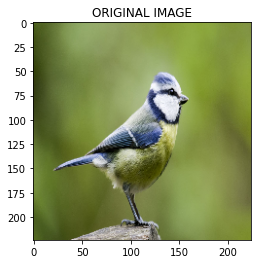

In [26]:

# load an image from file
image = load_img('drive/MyDrive/bird_1.jpg', target_size=(224, 224))
plt.imshow(image)
plt.title('ORIGINAL IMAGE')

(224, 224, 3)
0 0 0  -  (224, 224, 3)
14 0 1  -  (224, 224, 3)
28 0 2  -  (224, 224, 3)
42 0 3  -  (224, 224, 3)
56 0 4  -  (224, 224, 3)
70 0 5  -  (224, 224, 3)
84 0 6  -  (224, 224, 3)
98 0 7  -  (224, 224, 3)
112 0 8  -  (224, 224, 3)
126 0 9  -  (224, 224, 3)
140 0 10  -  (224, 224, 3)
154 0 11  -  (224, 224, 3)
168 0 12  -  (224, 224, 3)
182 0 13  -  (224, 224, 3)
196 0 14  -  (224, 224, 3)
210 0 15  -  (224, 224, 3)
0 14 16  -  (224, 224, 3)
14 14 17  -  (224, 224, 3)
28 14 18  -  (224, 224, 3)
42 14 19  -  (224, 224, 3)
56 14 20  -  (224, 224, 3)
70 14 21  -  (224, 224, 3)
84 14 22  -  (224, 224, 3)
98 14 23  -  (224, 224, 3)
112 14 24  -  (224, 224, 3)
126 14 25  -  (224, 224, 3)
140 14 26  -  (224, 224, 3)
154 14 27  -  (224, 224, 3)
168 14 28  -  (224, 224, 3)
182 14 29  -  (224, 224, 3)
196 14 30  -  (224, 224, 3)
210 14 31  -  (224, 224, 3)
0 28 32  -  (224, 224, 3)
14 28 33  -  (224, 224, 3)
28 28 34  -  (224, 224, 3)
42 28 35  -  (224, 224, 3)
56 28 36  -  (224, 224, 3)


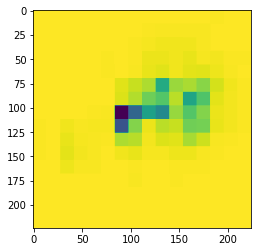

In [32]:

# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
temp = image[0]
print(temp.shape)
heatmap = np.zeros((224,224))
correct_class = np.argmax(yhat)
for n,(x,y,image) in enumerate(iter_occlusion(temp,14)):
    heatmap[x:x+14,y:y+14] = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))[0][correct_class]
    print(x,y,n,' - ',image.shape)
heatmap1 = heatmap/heatmap.max()
plt.imshow(heatmap)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


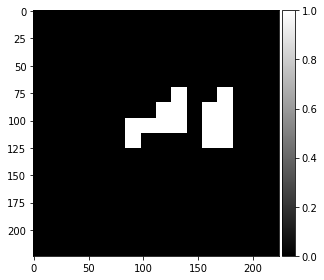

In [28]:

#creating mask from the standardised heatmap probabilities
mask = heatmap1 < 0.85
mask1 = mask *256
mask = mask.astype(int)
io.imshow(mask,cmap='gray')

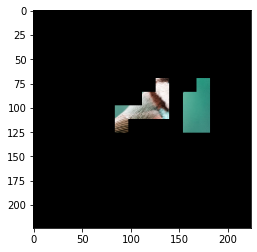

In [31]:

#read the image
image = cv2.imread('drive/MyDrive/bird_1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#resize image to appropriate dimensions
image = cv2.resize(image,(224,224))
mask = mask.astype('uint8')
#apply the mask to the image
final = cv2.bitwise_and(image,image,mask = mask)
final = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
#plot the final image
plt.imshow(final)